In [1]:
# -*- coding: utf-8 -*
# author Huangyin

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable

from flyai.dataset import Dataset
from flyai.source.base import DATA_PATH

from model import Model
from path import MODEL_PATH
from processor import DatasetFlyAI
from utils import Bunch
    
def train(args, model, device, train_loader,loss_fn, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if epoch==0:
            print("first epoch")
            break

def test(args, model, device, test_loader,loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    
def pretrained_net(net,class_num):
    if net=='densenet121':
        cnn = torchvision.models.densenet121(pretrained=True)
        for param in cnn.parameters():
            param.requires_grad = False
        num_features = cnn.classifier.in_features
        cnn.classifier = nn.Sequential(nn.Linear(num_features, class_num),nn.Sigmoid())
    elif net=='resnet34':
        cnn = torchvision.models.resnet34(pretrained=True)
        for param in cnn.parameters():
            param.requires_grad = False
        num_features = cnn.fc.in_features
        cnn.fc = nn.Sequential(nn.Linear(num_features, class_num),nn.Sigmoid())
    return cnn

def score(p,y):
    _,yp = torch.max(p.data,1)
    return (yp == y).sum().item()/len(y)


    
def eval(model, x_test, y_test):
    net.eval()
    batch_eval = model.batch_iter(x_test, y_test)
    total_acc = 0.0
    data_len = len(x_test)
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        outputs = net(x_batch)
        _, prediction = torch.max(outputs.data, 1)
        correct = (prediction == y_batch).sum().item()
        acc = correct / batch_len
        total_acc += acc * batch_len
    return total_acc / data_len
       



if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-e", "--EPOCHS", default=10, type=int, help="train epochs")
    parser.add_argument("-b", "--BATCH", default=32, type=int, help="batch size")
    args = parser.parse_args([])
    
  
    #settings
    settings = {
    'net':'densenet121',
    'nc':10,    
    'lr': 0.001,
    'seed': 1,
    'log_interval': 100,
    'save_model': True}
    print("1.settings",settings)
    settings = Bunch(settings)
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(settings.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    
    #load data
    data = Dataset()
    model = Model(data)

Monkey-patching not on the main thread; threading.main_thread().join() will hang from a greenlet


RuntimeError: cannot release un-acquired lock

In [2]:
from flyai.dataset import Dataset

The history saving thread hit an unexpected error (LoopExit('This operation would block forever', <Hub at 0x7fac5bb5f898 epoll pending=0 ref=0 fileno=49>)).History will not be written to the database.


In [4]:
# -*- coding: utf-8 -*

import gevent
import numpy
import os
from gevent import pool, monkey

from flyai.source.source import Source
from flyai.utils.yaml_helper import Yaml

In [2]:
import numpy

In [3]:
import os

In [5]:
monkey.patch_all(ssl=False)

Monkey-patching not on the main thread; threading.main_thread().join() will hang from a greenlet


The history saving thread hit an unexpected error (LoopExit('This operation would block forever', <Hub at 0x7f6130606638 epoll pending=0 ref=0 fileno=44>)).History will not be written to the database.


In [1]:
pool = pool.Pool(128)


class Dataset:
    def __init__(self, epochs=5, batch=32, val_batch=32, transformation=None, source=Source(),
                 processor_pka="processor",
                 processor_class=None, config_path=None):
        self.__db = source
        if epochs > 15:
            epochs = 15
        if batch > 256:
            batch = 256
        self.__BATCH = batch
        self.__VAL_BATCH = val_batch
        self.__STEP = round(self.__db.get_train_length() / batch) * epochs
        if config_path is not None:
            self.__model = Yaml(path=os.path.join(config_path, "app.yaml")).processor()
        else:
            self.__model = Yaml().processor()
        self.test_trans = False
        if processor_class is not None:
            clz = processor_class
        else:
            clz = self.__model['processor']

        if config_path is not None:
            config = config_path.replace(os.path.sep, '.')
            processor_pka = config + "." + processor_pka
            self.processor = self.create_instance(processor_pka, clz)
        else:
            self.processor = self.create_instance(processor_pka, clz)

        if transformation is not None:
            self.transformation = transformation
        else:
            try:
                if config_path is not None:
                    config = config_path.replace(os.path.sep, '.')
                    self.transformation = self.create_instance(config + '.transformation', 'Transformation')
                else:
                    self.transformation = self.create_instance('transformation', 'Transformation')
            except:
                self.transformation = None

    def get_step(self):
        return self.__STEP

    def get_train_length(self):
        return self.__db.get_train_length()

    def get_validation_length(self):
        return self.__db.get_validation_length()

    def next_train_batch(self):
        x_train, y_train = self.__db.next_train_batch(self.__BATCH)
        x_train = self.processor_x(x_train)
        y_train = self.processor_y(y_train)
        return x_train, y_train

    def next_validation_batch(self):
        x_val, y_val = self.__db.next_validation_batch(self.__VAL_BATCH)
        x_val = self.processor_x(x_val)
        y_val = self.processor_y(y_val)
        return x_val, y_val

    def next_batch(self, size=32, test_size=32, test_data=True):
        x_train, y_train, x_val, y_val = self.__db.next_batch(size, test_size)
        x_train = self.processor_x(x_train)
        y_train = self.processor_y(y_train)
        if test_data:
            x_val = self.processor_x(x_val)
            y_val = self.processor_y(y_val)
        else:
            x_val = None
            y_val = None
        if self.transformation is not None:
            if self.test_trans:
                x_train, y_train, _, _ = self.transformation.transformation_data(x_train, y_train)
            else:
                x_train, y_train, x_val, y_val = self.transformation.transformation_data(x_train, y_train, x_val,
                                                                                         y_val)
                self.test_trans = True
        return x_train, y_train, x_val, y_val

    def evaluate_source(self, path):
        x_val, y_val = self.__db.get_evaluate_data(path)
        return x_val, y_val

    def evaluate_data(self, path=None):
        if path is None:
            x_val, y_val = self.__db.get_validation_data()
        else:
            x_val, y_val = self.__db.get_evaluate_data(path)
        x_val = self.processor_x(x_val)
        y_val = self.processor_y(y_val)
        if self.transformation is not None:
            _, _, x_val, y_val = self.transformation.transformation_data(x_test=x_val, y_test=y_val)
        return x_val, y_val

    def evaluate_data_no_processor(self, path=None):
        if path is None:
            x_val, y_val = self.__db.get_validation_data()
        else:
            x_val, y_val = self.__db.get_evaluate_data(path)
        return x_val, y_val

    def get_all_data(self):
        x_train, y_train, x_val, y_val = self.__db.get_all_data()
        return x_train, y_train, x_val, y_val

    def get_all_validation_data(self):
        _, _, x_val, y_val = self.get_all_data()
        x_val = self.processor_x(x_val)
        y_val = self.processor_y(y_val)
        return x_val, y_val

    def get_all_processor_data(self):
        x_train, y_train, x_val, y_val = self.get_all_data()
        x_train = self.processor_x(x_train)
        y_train = self.processor_y(y_train)
        x_val = self.processor_x(x_val)
        y_val = self.processor_y(y_val)
        if self.transformation is not None:
            x_train, y_train, x_val, y_val = self.transformation.transformation_data(x_train, y_train, x_val, y_val)
        return x_train, y_train, x_val, y_val

    def processor_x(self, x_datas):
        threads = []
        for data in x_datas:
            threads.append(pool.spawn(self.get_method_dict, self.processor, self.__model['input_x'], **data))
        gevent.joinall(threads)
        processors = []
        init = False
        processor_len = 0
        for i, g in enumerate(threads):
            processor = g.value
            if not isinstance(processor, tuple):
                processor_len = 1
            if processor_len == 1:
                processors.append(numpy.array(processor))
            else:
                if not init:
                    processors = [[] for i in range(len(processor))]
                    init = True
                index = 0
                for item in processor:
                    processors[index].append(numpy.array(item))
                    index += 1
        if processor_len == 1:
            return numpy.concatenate([processors], axis=0)
        else:
            list = []
            for column in processors:
                list.append(numpy.concatenate([column], axis=0))
            return list

    def processor_y(self, y_datas):
        threads = []
        for data in y_datas:
            threads.append(pool.spawn(self.get_method_dict, self.processor, self.__model['input_y'], **data))
        gevent.joinall(threads)

        processors = []
        init = False
        processor_len = 0

        for i, g in enumerate(threads):
            processor = g.value
            if not isinstance(processor, tuple):
                processor_len = 1
            if processor_len == 1:
                processors.append(numpy.array(processor))
            else:
                if not init:
                    processors = [[] for i in range(len(processor))]
                    init = True
                index = 0
                for item in processor:
                    processors[index].append(numpy.array(item))
                    index += 1
        if processor_len == 1:
            return numpy.concatenate([processors], axis=0)
        else:
            list = []
            for column in processors:
                list.append(numpy.concatenate([column], axis=0))
            return list

    def predict_data(self, **data):
        processors = []
        processor = self.get_method_dict(self.processor, self.__model['output_x'], **data)
        processor_len = 0
        if not isinstance(processor, tuple):
            processors.append(numpy.array(processor))
            processor_len = 1
        else:
            processors = [[] for i in range(len(processor))]
            index = 0
            for item in processor:
                processors[index].append(numpy.array(item))
                index += 1
        if processor_len == 1:
            x = numpy.concatenate([processors], axis=0)
        else:
            list = []
            for column in processors:
                list.append(numpy.concatenate([column], axis=0))
            x = list
        if self.transformation is not None:
            x, _, _, _ = self.transformation.transformation_data(x)
        return x

    def to_categorys(self, predict):
        return self.get_method_list(self.processor, self.__model['output_y'], predict)

    def create_instance(self, module_name, class_name, *args, **kwargs):
        module_meta = __import__(module_name, globals(), locals(), [class_name])
        class_meta = getattr(module_meta, class_name)
        return class_meta(*args, **kwargs)

    def get_method_dict(self, clz, method_name, **args):
        m = getattr(clz, method_name)
        return m(**args)

    def get_method_list(self, clz, method_name, *args):
        m = getattr(clz, method_name)
        return m(*args)

Monkey-patching not on the main thread; threading.main_thread().join() will hang from a greenlet


In [5]:
data.get_all_data()

([{'image_path': 'images/027541.jpg'},
  {'image_path': 'images/037925.jpg'},
  {'image_path': 'images/055219.jpg'},
  {'image_path': 'images/147211.jpg'},
  {'image_path': 'images/197074.jpg'},
  {'image_path': 'images/095169.jpg'},
  {'image_path': 'images/100039.jpg'},
  {'image_path': 'images/198471.jpg'},
  {'image_path': 'images/106092.jpg'},
  {'image_path': 'images/094540.jpg'},
  {'image_path': 'images/147333.jpg'},
  {'image_path': 'images/084266.jpg'},
  {'image_path': 'images/185489.jpg'},
  {'image_path': 'images/101718.jpg'},
  {'image_path': 'images/036450.jpg'},
  {'image_path': 'images/084660.jpg'},
  {'image_path': 'images/182537.jpg'},
  {'image_path': 'images/152203.jpg'},
  {'image_path': 'images/052759.jpg'},
  {'image_path': 'images/167428.jpg'},
  {'image_path': 'images/027292.jpg'},
  {'image_path': 'images/159482.jpg'},
  {'image_path': 'images/106071.jpg'},
  {'image_path': 'images/183914.jpg'},
  {'image_path': 'images/132328.jpg'},
  {'image_path': 'images/

In [19]:
import numpy as np

In [27]:
arr = np.random.uniform(size=(256,256,3))*255

In [22]:
from PIL import Image

In [51]:
img = Image.fromarray(normtoimg(vtx),"RGB")

In [30]:
from matplotlib import pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


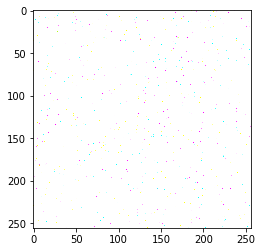

In [31]:
plt.imshow(arr,interpolation="nearest")

In [33]:
import netCDF4

In [48]:
vtx = netCDF4.Dataset('/home/changebio/Proj/github/GWAS/data/mvtx_res_arr.nc4','r')

In [49]:
vtx = vtx.variables['var1_1'][:].data

In [50]:
vtx.shape

(180, 180, 3)

In [43]:
def normtoimg(a):
    # Normalised [0,255] as integer
    c = 255*(a - np.min(a))/np.ptp(a).astype(int)
    return c

In [38]:
a = np.random.rand(3,2)

In [39]:
a

array([[0.13975202, 0.90808654],
       [0.74290479, 0.6659215 ],
       [0.57541325, 0.83489421]])

In [42]:
?np.ptp

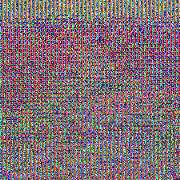

In [52]:
img

In [ ]:
    train_dataset = DatasetFlyAI(root=DATA_PATH,df=data.__db.source.data,transform=train_transforms)
    val_dataset = DatasetFlyAI(root=DATA_PATH,df=data.__db.source.val,transform=val_transforms)
    
    
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.BATCH, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=args.BATCH, shuffle=True, **kwargs)
    n_train = len(train_dataset)
    batch_train = n_train/args.BATCH
    print(args.BATCH,n_train/args.BATCH)
    n_test = len(val_dataset)
    batch_test = n_test/args.BATCH
    print("2. load data. train_dataset %d,batch %d, val_dataset %d, batch %d." % (n_train,batch_train,n_test,batch_test))
    

In [39]:
import random

_,_,x_test,y_text = data.get_all_data()
test_idx = random.sample(range(len(x_test)),10)

In [69]:
numpy.around([1.11,2.0,33],decimals=1).astype('int')

array([ 1,  2, 33])

In [75]:
numpy.array([ 52.,  73.,  82.,  59.,  82., 159.,  57., 184., 115., 151.])[0]

52.0

In [72]:
data.evaluate_data_no_processor()

([{'image_path': 'images/027541.jpg'},
  {'image_path': 'images/037925.jpg'},
  {'image_path': 'images/055219.jpg'},
  {'image_path': 'images/147211.jpg'},
  {'image_path': 'images/197074.jpg'},
  {'image_path': 'images/095169.jpg'},
  {'image_path': 'images/100039.jpg'},
  {'image_path': 'images/198471.jpg'},
  {'image_path': 'images/106092.jpg'},
  {'image_path': 'images/094540.jpg'},
  {'image_path': 'images/147333.jpg'},
  {'image_path': 'images/084266.jpg'},
  {'image_path': 'images/185489.jpg'},
  {'image_path': 'images/101718.jpg'},
  {'image_path': 'images/036450.jpg'},
  {'image_path': 'images/084660.jpg'},
  {'image_path': 'images/182537.jpg'},
  {'image_path': 'images/152203.jpg'},
  {'image_path': 'images/052759.jpg'},
  {'image_path': 'images/167428.jpg'},
  {'image_path': 'images/027292.jpg'},
  {'image_path': 'images/159482.jpg'},
  {'image_path': 'images/106071.jpg'},
  {'image_path': 'images/183914.jpg'},
  {'image_path': 'images/132328.jpg'},
  {'image_path': 'images/

In [51]:
for i in range(0,100,7):
    print(i)

0
7
14
21
28
35
42
49
56
63
70
77
84
91
98


In [65]:
data.predict_data(image_path=[str(idata.db.source.data['image_path'])

TypeError: expected str, bytes or os.PathLike object, not Series

In [62]:
data.db.source.data['image_path']

0     images/027541.jpg
1     images/037925.jpg
2     images/055219.jpg
3     images/147211.jpg
4     images/197074.jpg
5     images/095169.jpg
6     images/100039.jpg
7     images/198471.jpg
8     images/106092.jpg
9     images/094540.jpg
10    images/147333.jpg
11    images/084266.jpg
12    images/185489.jpg
13    images/101718.jpg
14    images/036450.jpg
15    images/084660.jpg
16    images/182537.jpg
17    images/152203.jpg
18    images/052759.jpg
19    images/167428.jpg
20    images/027292.jpg
21    images/159482.jpg
22    images/106071.jpg
23    images/183914.jpg
24    images/132328.jpg
25    images/072856.jpg
26    images/135909.jpg
27    images/012559.jpg
28    images/021334.jpg
29    images/191413.jpg
            ...        
70    images/110146.jpg
71    images/025867.jpg
72    images/065627.jpg
73    images/121039.jpg
74    images/066431.jpg
75    images/181163.jpg
76    images/171273.jpg
77    images/085678.jpg
78    images/111418.jpg
79    images/157442.jpg
80    images/037

In [55]:
a=numpy.array([[1,2,3],[1.1,0.5,2.3]])

In [59]:
[i*[1,2,3] for i in a]

[array([1., 4., 9.]), array([1.1, 1. , 6.9])]

In [60]:
[1,2]+[3,4]

[1, 2, 3, 4]

In [45]:
x_test[5]

{'image_path': 'images/095169.jpg'}

In [33]:
print(model.predict_all(x_test[test_idx]),y_text[test_idx])

In [38]:
len(data.get_all_data()[0])

100

In [32]:
data.get_all_data()[0:10]

([{'image_path': 'images/027541.jpg'},
  {'image_path': 'images/037925.jpg'},
  {'image_path': 'images/055219.jpg'},
  {'image_path': 'images/147211.jpg'},
  {'image_path': 'images/197074.jpg'},
  {'image_path': 'images/095169.jpg'},
  {'image_path': 'images/100039.jpg'},
  {'image_path': 'images/198471.jpg'},
  {'image_path': 'images/106092.jpg'},
  {'image_path': 'images/094540.jpg'},
  {'image_path': 'images/147333.jpg'},
  {'image_path': 'images/084266.jpg'},
  {'image_path': 'images/185489.jpg'},
  {'image_path': 'images/101718.jpg'},
  {'image_path': 'images/036450.jpg'},
  {'image_path': 'images/084660.jpg'},
  {'image_path': 'images/182537.jpg'},
  {'image_path': 'images/152203.jpg'},
  {'image_path': 'images/052759.jpg'},
  {'image_path': 'images/167428.jpg'},
  {'image_path': 'images/027292.jpg'},
  {'image_path': 'images/159482.jpg'},
  {'image_path': 'images/106071.jpg'},
  {'image_path': 'images/183914.jpg'},
  {'image_path': 'images/132328.jpg'},
  {'image_path': 'images/

In [6]:
from flyai.processor.download import check_download

In [9]:
from PIL import Image

In [47]:
temp = numpy.array([0.5,0.8,1.3,0.7,1.2])

In [48]:
temp[temp>1]=1

In [49]:
temp

array([0.5, 0.8, 1. , 0.7, 1. ])

In [ ]:
enumerate

In [13]:
for i in data.db.source.data['image_path']:
    path = check_download(i, DATA_PATH)
    image = Image.open(path)
    print(image.size)

(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)

In [25]:
m = nn.AdaptiveAvgPool2d((1,1))
input = torch.randn(1, 64, 8, 9)
output = m(input)

In [26]:
output.shape

torch.Size([1, 64, 1, 1])

In [29]:
torch.mean(input[0,1,:,:])

tensor(-0.1366)

In [27]:
output

tensor([[[[-1.0466e-01]],

         [[-1.3657e-01]],

         [[-7.0819e-02]],

         [[ 1.2727e-02]],

         [[ 3.7998e-02]],

         [[-1.4897e-01]],

         [[ 2.2177e-01]],

         [[ 1.1189e-01]],

         [[-6.4433e-02]],

         [[-6.6439e-02]],

         [[ 1.1478e-01]],

         [[-2.5622e-01]],

         [[-1.8094e-01]],

         [[ 1.6396e-01]],

         [[ 3.4767e-01]],

         [[-6.0875e-02]],

         [[-3.2147e-02]],

         [[ 1.7555e-02]],

         [[ 1.7990e-01]],

         [[-1.3181e-01]],

         [[-2.3309e-01]],

         [[-8.0199e-03]],

         [[ 8.7453e-02]],

         [[-2.0393e-01]],

         [[ 2.1647e-04]],

         [[-7.8312e-02]],

         [[-1.2678e-01]],

         [[ 1.1007e-02]],

         [[-2.5014e-03]],

         [[-5.3984e-02]],

         [[-5.6841e-02]],

         [[-2.3778e-02]],

         [[-1.1692e-02]],

         [[-1.3351e-01]],

         [[-1.3644e-01]],

         [[-4.7495e-02]],

         [[ 2.2392e-02]],

 

In [19]:
import numpy

In [21]:
numpy.array([178,218])*224/178

array([224.        , 274.33707865])

In [2]:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    train_transforms= transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    train_dataset = DatasetFlyAI(root=DATA_PATH,df=data.db.source.data,transform=train_transforms)
    val_dataset = DatasetFlyAI(root=DATA_PATH,df=data.db.source.test,transform=val_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.BATCH, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=args.BATCH, shuffle=True, **kwargs)
    n_train = len(train_dataset)
    batch_train = n_train/args.BATCH
    print(args.BATCH,n_train/args.BATCH)
    n_test = len(val_dataset)
    batch_test = n_test/args.BATCH
    print("2. load data. train_dataset %d,batch %d, val_dataset %d, batch %d." % (n_train,batch_train,n_test,batch_test))

    #load net structure
    print("3.load net structure: %s, number of class: %d" % (settings.net,settings.nc))
    net = pretrained_net(settings.net,settings.nc)
    gpu = torch.cuda.is_available()
    if gpu:
        net.cuda()
    #optimize and loss
    print("4.optimize and loss. learning rate %g" % settings.lr)
    optimizer = Adam(net.parameters(), lr=settings.lr, betas=(0.9, 0.999)) 
    #optimizer = Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))  
    loss_fn = nn.MSELoss()

    #train and test
    print("5.***************train and test*********************")
    best_accuracy = 0
    train_iter = iter(train_loader)
    batch_idx = 0
    losses=[]
    for i in range(args.EPOCHS):
        #net.train()
        #x_train, y_train, x_test, y_test = data.next_batch(args.BATCH) 
        #x_train = torch.from_numpy(x_train)
        #y_train = torch.from_numpy(y_train)
        #x_train = x_train.float()
        try:
            batch_idx +=1
            x_train, y_train = next(train_iter)
            y_train = y_train.float()/178
            #print(batch_idx,"data len",len(x_train),len(y_train))
        except:
            batch_idx = 0
            train_iter = iter(train_loader)
            x_train, y_train = next(train_iter)
            y_train = y_train.float()/178
            print(len(x_train),len(y_train),"data len")

        if gpu:
            x_train = Variable(x_train.cuda())
            y_train = Variable(y_train.cuda())


        outputs = net(x_train)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % settings.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i, batch_idx * len(x_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    if settings.save_model:       
        model.save_model(net, MODEL_PATH, overwrite=True)
     

32 3.125
2. load data. train_dataset 100,batch 3, val_dataset 100, batch 3.
3.load net structure: densenet121, number of class: 10


/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


4.optimize and loss. learning rate 0.001
5.***************train and test*********************
32 32 data len
Train Epoch: 4 [0/100 (0%)]	Loss: 0.026880
32 32 data len
Train Epoch: 8 [0/100 (0%)]	Loss: 0.002476


In [16]:
train_dataset.df.to_csv(os.sys.path[0])

11

In [21]:
import sys

In [20]:
[train_dataset.df.iloc[:,i].value_counts() for i in range(train_dataset.df.shape[1])]

images/155153.jpg    1
images/135909.jpg    1
images/037307.jpg    1
images/010766.jpg    1
images/013425.jpg    1
images/128646.jpg    1
images/197074.jpg    1
images/010521.jpg    1
images/100039.jpg    1
images/167428.jpg    1
images/121202.jpg    1
images/072856.jpg    1
images/114674.jpg    1
images/121039.jpg    1
images/176297.jpg    1
images/025264.jpg    1
images/019455.jpg    1
images/020579.jpg    1
images/027292.jpg    1
images/051210.jpg    1
images/001476.jpg    1
images/149298.jpg    1
images/085678.jpg    1
images/027541.jpg    1
images/055219.jpg    1
images/155520.jpg    1
images/183914.jpg    1
images/136068.jpg    1
images/074369.jpg    1
images/147333.jpg    1
                    ..
images/114906.jpg    1
images/067937.jpg    1
images/104426.jpg    1
images/065627.jpg    1
images/198177.jpg    1
images/181163.jpg    1
images/084266.jpg    1
images/150941.jpg    1
images/037925.jpg    1
images/146698.jpg    1
images/185489.jpg    1
images/101605.jpg    1
images/1174

[None, None, None, None, None, None, None, None, None, None, None]

In [24]:
a=train_dataset.df.describe()

In [29]:
list(a.iloc[:,0])

[100.0, 69.75, 1.6166744767071581, 67.0, 69.0, 70.0, 70.0, 77.0]

In [27]:
[list(i) for i in a]

[['l', 'e', 'f', 't', 'e', 'y', 'e', '_', 'x'],
 ['l', 'e', 'f', 't', 'e', 'y', 'e', '_', 'y'],
 ['r', 'i', 'g', 'h', 't', 'e', 'y', 'e', '_', 'x'],
 ['r', 'i', 'g', 'h', 't', 'e', 'y', 'e', '_', 'y'],
 ['n', 'o', 's', 'e', '_', 'x'],
 ['n', 'o', 's', 'e', '_', 'y'],
 ['l', 'e', 'f', 't', 'm', 'o', 'u', 't', 'h', '_', 'x'],
 ['l', 'e', 'f', 't', 'm', 'o', 'u', 't', 'h', '_', 'y'],
 ['r', 'i', 'g', 'h', 't', 'm', 'o', 'u', 't', 'h', '_', 'x'],
 ['r', 'i', 'g', 'h', 't', 'm', 'o', 'u', 't', 'h', '_', 'y']]

In [23]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

In [91]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
d

In [87]:
loss.item()

0.006559955887496471

In [ ]:
credits